## 1. 환경 설정  
필요 라이브러리를 임포트하고, 한글 폰트를 설정합니다.

In [64]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import re

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

In [66]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

## 2. 병원정보서비스 분석  

### 2-1. 데이터 전처리   

데이터 : csv로 변환한 엑셀파일. 데이터의 구조를 살펴보고 전처리 작업을 진행합니다.

In [67]:
df = pd.read_csv(r"C:\Users\zappe\Desktop\Test_for_python\데이터분석개론\team_proj\전국 병의원 및 약국 현황 2024.12\병원정보서비스 2024.12.csv",encoding='utf-8')

In [68]:
df.head() #데이터 구조 확인

,암호화요양기호,요양기관명,종별코드,종별코드명,시도코드,시도코드명,시군구코드,시군구코드명,읍면동,우편번호,...,치과인턴 인원수,치과레지던트 인원수,치과전문의 인원수,한방일반의 인원수,한방인턴 인원수,한방레지던트 인원수,한방전문의 인원수,조산사 인원수,좌표(X),좌표(Y)
0,JDQ4MTYyMiM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 성빈센트병원,1,상급종합,310000,경기,310603,수원팔달구,지동,16247,...,0,0,7,0,0,0,0,0,127.027427,37.277985
1,JDQ4MTYyMiM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교인천성모병원,1,상급종합,220000,인천,220003,인천부평구,부평동,21431,...,0,0,3,0,0,0,0,0,126.724899,37.484831
2,JDQ4MTYyMiM1MSMkMSMkNCMkODkkMzgxMzUxIzExIyQxIy...,강릉아산병원,1,상급종합,320000,강원,320100,강릉시,사천면,25440,...,0,0,2,0,0,0,0,0,128.857841,37.818433
3,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,강북삼성병원,1,상급종합,110000,서울,110016,종로구,평동,3181,...,0,0,4,0,0,0,0,0,126.967750,37.568408
4,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,건국대학교병원,1,상급종합,110000,서울,110023,광진구,화양동,5030,...,0,0,2,0,0,0,0,0,127.071828,37.540376


In [69]:
df.info

<bound method DataFrame.info of                                                  암호화요양기호          요양기관명  종별코드  \
0      JDQ4MTYyMiM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...  가톨릭대학교 성빈센트병원     1   
1      JDQ4MTYyMiM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...   가톨릭대학교인천성모병원     1   
2      JDQ4MTYyMiM1MSMkMSMkNCMkODkkMzgxMzUxIzExIyQxIy...         강릉아산병원     1   
3      JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...         강북삼성병원     1   
4      JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...        건국대학교병원     1   
...                                                  ...            ...   ...   
78477  JDQ4MTg4MSM1MSMkMSMkNCMkMTMkMzgxNzAyIzUxIyQxIy...      힘찬세상경희한의원    93   
78478  JDQ4MTAxMiM1MSMkMSMkMCMkMTMkNDgxOTYxIzIxIyQxIy...          힘찬한의원    93   
78479  JDQ4MTYyMiM2MSMkMSMkMiMkMTMkNDgxOTYxIzExIyQxIy...          힘찬한의원    93   
78480  JDQ4MTYyMiM4MSMkMSMkNCMkMTMkNDgxMzUxIzMxIyQxIy...          힘찬한의원    93   
78481  JDU4MTI3MSM1MSMkMSMkMCMkMTMkNDgxOTYxIzMxIyQxIy...          힘찬한의원    93

In [70]:
df.isnull().sum() #x,y 좌표가 좀 비어있음.

암호화요양기호           0
요양기관명             0
종별코드              0
종별코드명             0
시도코드              0
시도코드명             0
시군구코드             0
시군구코드명            0
읍면동             520
우편번호              0
주소                0
전화번호            484
병원홈페이지        70134
개설일자              0
총의사수              0
의과일반의 인원수         0
의과인턴 인원수          0
의과레지던트 인원수        0
의과전문의 인원수         0
치과일반의 인원수         0
치과인턴 인원수          0
치과레지던트 인원수        0
치과전문의 인원수         0
한방일반의 인원수         0
한방인턴 인원수          0
한방레지던트 인원수        0
한방전문의 인원수         0
조산사 인원수           0
좌표(X)          1488
좌표(Y)          1488
dtype: int64

In [57]:
df.columns # 컬럼 확인, 불필요한 컬럼 삭제

Index(['암호화요양기호', '요양기관명', '종별코드', '종별코드명', '시도코드', '시도코드명', '시군구코드', '시군구코드명',
       '읍면동', '우편번호', '주소', '전화번호', '병원홈페이지', '개설일자', '총의사수', '의과일반의 인원수',
       '의과인턴 인원수', '의과레지던트 인원수', '의과전문의 인원수', '치과일반의 인원수', '치과인턴 인원수',
       '치과레지던트 인원수', '치과전문의 인원수', '한방일반의 인원수', '한방인턴 인원수', '한방레지던트 인원수',
       '한방전문의 인원수', '조산사 인원수', '좌표(X)', '좌표(Y)'],
      dtype='object')

In [58]:
df2 = df.drop(columns=['암호화요양기호','전화번호','병원홈페이지','종별코드','시도코드','시군구코드','개설일자','치과일반의 인원수','치과인턴 인원수','치과레지던트 인원수','치과전문의 인원수','조산사 인원수'])

In [59]:
df2.head()

,요양기관명,종별코드명,시도코드명,시군구코드명,읍면동,우편번호,주소,총의사수,의과일반의 인원수,의과인턴 인원수,의과레지던트 인원수,의과전문의 인원수,한방일반의 인원수,한방인턴 인원수,한방레지던트 인원수,한방전문의 인원수,좌표(X),좌표(Y)
0,가톨릭대학교 성빈센트병원,상급종합,경기,수원팔달구,지동,16247,"경기도 수원시 팔달구 중부대로 93, (지동)",251,0,0,6,238,0,0,0,0,127.027427,37.277985
1,가톨릭대학교인천성모병원,상급종합,인천,인천부평구,부평동,21431,"인천광역시 부평구 동수로 56, (부평동)",248,3,0,3,238,0,0,0,0,126.724899,37.484831
2,강릉아산병원,상급종합,강원,강릉시,사천면,25440,"강원특별자치도 강릉시 사천면 방동길 38, (사천면)",176,8,0,12,154,0,0,0,0,128.857841,37.818433
3,강북삼성병원,상급종합,서울,종로구,평동,3181,"서울특별시 종로구 새문안로 29, (평동)",278,0,1,11,258,0,0,0,0,126.967750,37.568408
4,건국대학교병원,상급종합,서울,광진구,화양동,5030,"서울특별시 광진구 능동로 120-1, (화양동)",251,1,0,15,233,0,0,0,0,127.071828,37.540376


In [60]:
def get_coords_vworld(address, vworld_api_key):
    url = "https://api.vworld.kr/req/address"
    params = {
        "service": "address",
        "request": "getcoord",
        "version": "2.0",
        "crs": "EPSG:4326",
        "address": address,
        "format": "json",
        "type": "ROAD",
        "key": vworld_api_key
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        result = response.json()
        try:
            x = result['response']['result']['point']['x']
            y = result['response']['result']['point']['y']
            return float(x), float(y)
        except:
            return None, None
    return None, None

def fill_missing_coords(df, api_key, delay=0.3):

    for idx, row in df.iterrows():

        full_address = row['주소']
        x, y = get_coords_vworld(full_address, api_key)
        
        if x and y:
            df.at[idx, '좌표(X)'] = x
            df.at[idx, '좌표(Y)'] = y
            print(f"✅ [{idx}] 좌표 채움: {x}, {y}")
        else:
            print(f"❌ [{idx}] 좌표 못 찾음: {full_address}")
        
        time.sleep(delay)  # 요청 간 시간 간격 (초당 3~5회 이하 추천)

    return df


In [61]:
vworld_key = "239AEE7D-C80A-374B-B39F-A2E7A556C870"

In [62]:
df_null = df[df['좌표(X)'].isna()].copy()
df_null.info

<bound method DataFrame.info of                                                  암호화요양기호                요양기관명  \
222    JDQ4MTYyMiM4MSMkMSMkNCMkODkkMzgxMzUxIzExIyQxIy...  의료법인 문병욱의료재단 진주고려병원   
404    JDQ4MTYyMiM3MSMkMSMkMCMkOTkkMzgxMzUxIzMxIyQxIy...                 가람병원   
595    JDQ4MTYyMiM1MSMkMSMkMCMkOTkkMzgxOTYxIzIxIyQxIy...           다산청아람어린이병원   
612    JDQ4MTYyMiM4MSMkMSMkMCMkOTkkMzgxOTYxIzExIyQxIy...         대구제이케이(JK)병원   
901    JDQ4MTYyMiM1MSMkMSMkMCMkOTkkMzgxOTYxIzIxIyQxIy...             샘물호스피스병원   
...                                                  ...                  ...   
78192  JDQ4MTg4MSM1MSMkMSMkOCMkMTMkMzgxNzAyIzExIyQxIy...                화리한의원   
78231  JDQ4MTg4MSM1MSMkMSMkNCMkMTMkNDgxMTkxIzQxIyQyIy...               화이팅한의원   
78379  JDQ4MTg4MSM1MSMkMSMkNCMkMTMkNDgxMTkxIzQxIyQxIy...                효인한의원   
78467  JDQ4MTg4MSM1MSMkMSMkNCMkMTMkNDgxMTkxIzUxIyQxIy...              희희호호한의원   
78476  JDQ4MTYyMiM2MSMkMSMkMiMkMTMkNDgxOTYxIzIxIyQxIy...                힘센한의원

In [63]:
df_null = fill_missing_coords(df_null, vworld_key)

✅ [222] 좌표 채움: 128.092053692, 35.178482488
✅ [404] 좌표 채움: 126.883887496, 35.174034924
✅ [595] 좌표 채움: 127.156119831, 37.625798083
✅ [612] 좌표 채움: 128.615415833, 35.854110789
✅ [901] 좌표 채움: 127.413820079, 37.138540741
✅ [942] 좌표 채움: 127.380595362, 36.345422888
✅ [1000] 좌표 채움: 129.00966708, 35.105729691
✅ [1070] 좌표 채움: 126.939098959, 37.396562315
✅ [1143] 좌표 채움: 127.047835781, 37.726541226
✅ [1163] 좌표 채움: 127.391645894, 36.340067254
✅ [1181] 좌표 채움: 126.884123765, 35.159122448
✅ [1198] 좌표 채움: 127.148454021, 37.271932782
✅ [1215] 좌표 채움: 128.617453052, 35.895286229
✅ [1324] 좌표 채움: 127.57549641, 36.777508741
✅ [1456] 좌표 채움: 127.334397066, 36.301991661
✅ [1548] 좌표 채움: 127.916787671, 35.687347682
✅ [1612] 좌표 채움: 127.495070498, 36.670963472
✅ [1614] 좌표 채움: 127.485884174, 36.636901209
✅ [1722] 좌표 채움: 129.014516634, 35.327214591
✅ [1745] 좌표 채움: 128.651910114, 35.855445545
✅ [1757] 좌표 채움: 127.238330961, 37.650088031
✅ [2288] 좌표 채움: 128.624890285, 35.843136114
✅ [2318] 좌표 채움: 126.809032346, 37.368925

KeyboardInterrupt: 

In [ ]:
df_without_missing = df2[~df2.index.isin(df_null.index)]
df_final = pd.concat([df_without_missing, df_null], ignore_index=True)
df_final = df_final.sort_index()

In [ ]:
df_final.isnull().sum() # 좌표가 다 채워졌는지 확인

요양기관명           0
종별코드명           0
시도코드명           0
시군구코드명          0
읍면동           520
우편번호            0
주소              0
총의사수            0
의과일반의 인원수       0
의과인턴 인원수        0
의과레지던트 인원수      0
의과전문의 인원수       0
한방일반의 인원수       0
한방인턴 인원수        0
한방레지던트 인원수      0
한방전문의 인원수       0
좌표(X)          23
좌표(Y)          23
dtype: int64

In [71]:
df_final.drop(columns=['암호화요양기호','전화번호','병원홈페이지','종별코드','시도코드','시군구코드','개설일자','치과일반의 인원수','치과인턴 인원수','치과레지던트 인원수','치과전문의 인원수','조산사 인원수'],inplace=True) # 불필요한 컬럼 삭제 

KeyError: "['암호화요양기호', '전화번호', '병원홈페이지', '종별코드', '시도코드', '시군구코드', '개설일자', '치과일반의 인원수', '치과인턴 인원수', '치과레지던트 인원수', '치과전문의 인원수', '조산사 인원수'] not found in axis"

In [72]:
#df_final 만든 버전
df_final = pd.read_csv(r"C:\Users\zappe\Desktop\Test_for_python\데이터분석개론\team_proj\df_final.csv",encoding='utf-8')

In [73]:
df_final['시도코드명'] = df_final['시도코드명'].replace('세종시', '세종')

In [74]:
general_hospitals = []
oriental_hospitals = []

for index, row in df_final.iterrows(): #행반복복
    if row['의과일반의 인원수'] > 0 or row['의과인턴 인원수'] > 0 or row['의과레지던트 인원수'] > 0 or row['의과전문의 인원수'] > 0:
        general_hospitals.append(row)
    elif row['한방일반의 인원수'] > 0 or row['한방인턴 인원수'] > 0 or row['한방레지던트 인원수'] > 0 or row['한방전문의 인원수'] > 0:
        oriental_hospitals.append(row)

df_general = pd.DataFrame(general_hospitals)
df_oriental = pd.DataFrame(oriental_hospitals)

In [75]:
df_general.drop(columns=['한방일반의 인원수','한방인턴 인원수','한방레지던트 인원수','한방전문의 인원수'], inplace=True)
df_oriental.drop(columns=['의과일반의 인원수','의과인턴 인원수','의과레지던트 인원수','의과전문의 인원수'], inplace=True)

In [76]:
df_general.head()

,요양기관명,종별코드명,시도코드명,시군구코드명,읍면동,우편번호,주소,총의사수,의과일반의 인원수,의과인턴 인원수,의과레지던트 인원수,의과전문의 인원수,좌표(X),좌표(Y)
0,가톨릭대학교 성빈센트병원,상급종합,경기,수원팔달구,지동,16247,"경기도 수원시 팔달구 중부대로 93, (지동)",251,0,0,6,238,127.027427,37.277985
1,가톨릭대학교인천성모병원,상급종합,인천,인천부평구,부평동,21431,"인천광역시 부평구 동수로 56, (부평동)",248,3,0,3,238,126.724899,37.484831
2,강릉아산병원,상급종합,강원,강릉시,사천면,25440,"강원특별자치도 강릉시 사천면 방동길 38, (사천면)",176,8,0,12,154,128.857841,37.818433
3,강북삼성병원,상급종합,서울,종로구,평동,3181,"서울특별시 종로구 새문안로 29, (평동)",278,0,1,11,258,126.967750,37.568408
4,건국대학교병원,상급종합,서울,광진구,화양동,5030,"서울특별시 광진구 능동로 120-1, (화양동)",251,1,0,15,233,127.071828,37.540376


In [77]:
df_oriental.tail()

,요양기관명,종별코드명,시도코드명,시군구코드명,읍면동,우편번호,주소,총의사수,한방일반의 인원수,한방인턴 인원수,한방레지던트 인원수,한방전문의 인원수,좌표(X),좌표(Y)
78477,화리한의원,한의원,서울,서초구,방배동,6568,"서울특별시 서초구 서초대로 3-4, 105호 (방배동, 디오슈페리움1차)",1,1,0,0,0,126.983124,37.486042
78478,화이팅한의원,한의원,서울,양천구,신정동,8093,"서울특별시 양천구 목동동로 67, 2층 (신정동)",2,2,0,0,0,126.862500,37.515710
78479,효인한의원,한의원,서울,은평구,불광동,3349,"서울특별시 은평구 연서로 274, 2층 (불광동)",1,0,0,0,1,126.925097,37.620572
78480,희희호호한의원,한의원,서울,강남구,대치동,6198,"서울특별시 강남구 선릉로 408, 3층 (대치동)",2,2,0,0,0,127.050740,37.501412
78481,힘센한의원,한의원,충남,논산시,화지동,32950,"충청남도 논산시 중앙로491번길 12, (화지동)",1,1,0,0,0,127.081874,36.206160


### 2-2. 데이터 시각화
데이터를 시각화하여 전체적인 맥락을 파악한다.

<Axes: xlabel='좌표(X)', ylabel='좌표(Y)'>

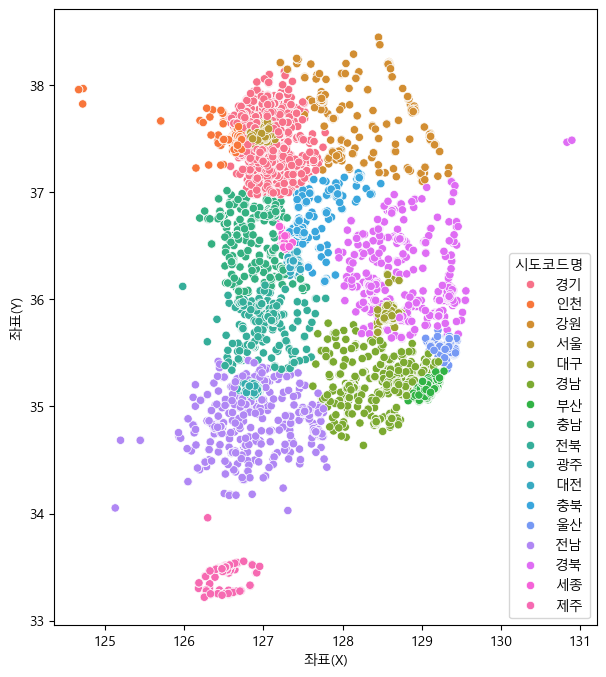

In [78]:
plt.figure(figsize=(7,8))
sns.scatterplot(data=df_general, x='좌표(X)', y='좌표(Y)', hue='시도코드명')

<Axes: xlabel='좌표(X)', ylabel='좌표(Y)'>

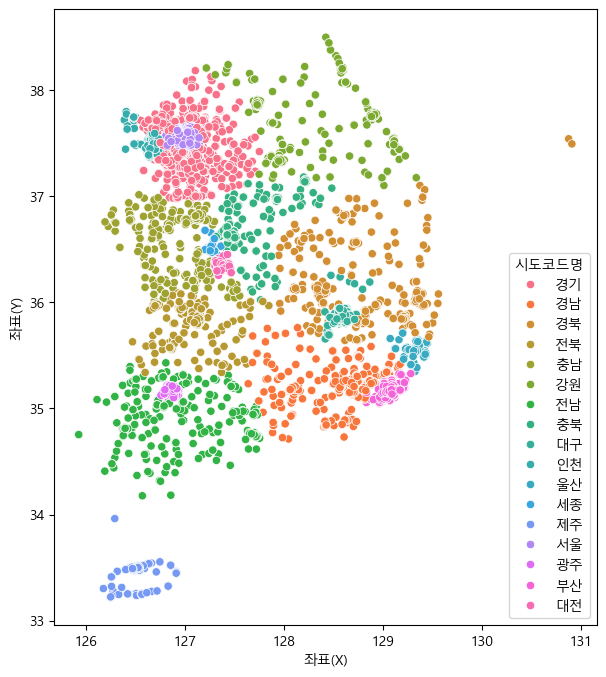

In [79]:
plt.figure(figsize=(7,8))
sns.scatterplot(data=df_oriental, x='좌표(X)', y='좌표(Y)', hue='시도코드명')

<Axes: xlabel='좌표(X)', ylabel='좌표(Y)'>

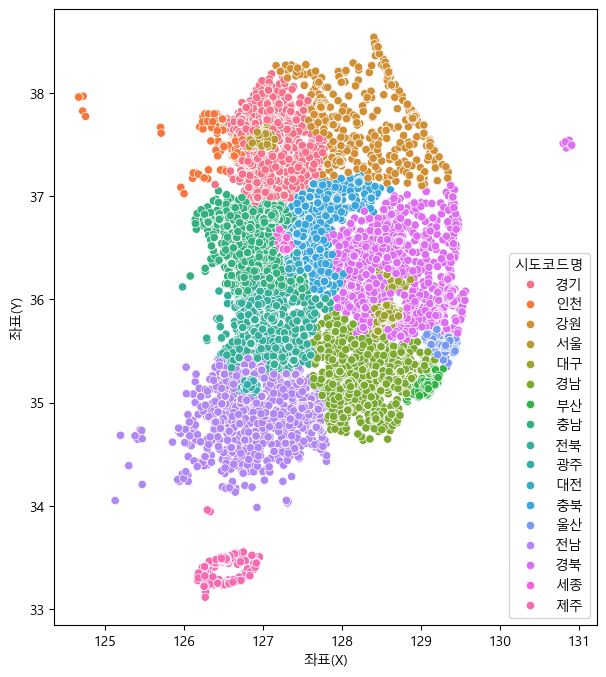

In [80]:
plt.figure(figsize=(7,8))
sns.scatterplot(data=df_final, x='좌표(X)', y='좌표(Y)', hue='시도코드명')

### 2-3. 병원 밀도 분석
인구 수와 비교하여 1만명 당 존재하는 병원 개수를 조사하였습니다.

In [81]:
df_general['시도코드명'].unique()

array(['경기', '인천', '강원', '서울', '대구', '경남', '부산', '충남', '전북', '광주', '대전',
       '충북', '울산', '전남', '경북', '세종', '제주'], dtype=object)

In [82]:
data_human = {
    '시도명': ['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종', '경기',
             '강원', '충북', '충남', '전북', '전남', '경북', '경남', '제주'],
    '인구(천명)': [15567, 4282, 2679, 2788, 2933, 2728, 1048, 818, 1342,
             91, 219, 265, 220, 144, 138, 312, 365],
    '인구밀도': [9400, 3284, 2360, 3009, 1463, 1474, 1106, 387, 13781,
                1525, 1627, 2204, 1768, 1768, 2611, 3267, 677]
} # 시도별 인구수 및 인구밀도 데이터. 2023년 확정인구 기준. 
df_human = pd.DataFrame(data_human).set_index('시도명')

In [83]:
hospital_counts = df_final['시도코드명'].value_counts()
df_human['병원수'] = hospital_counts # 시도별 병원 수 데이터 추가
df_human['병원수'] = df_human['병원수'].fillna(0) # 병원 수가 없는 시도는 0으로 채움

In [84]:
df_human['병원밀도(개/1만명)'] = (df_human['병원수'] / (df_human['인구(천명)'] * 1000)) * 10000
df_human = df_human.sort_values('병원밀도(개/1만명)')

In [85]:
df_human

,인구(천명),인구밀도,병원수,병원밀도(개/1만명)
시도명,,,,
세종,818,387,464,5.672372
광주,2933,1463,2326,7.930447
대전,2728,1474,2355,8.632698
서울,15567,9400,19277,12.383247
부산,4282,3284,5585,13.042971
울산,1048,1106,1429,13.635496
인천,2788,3009,3818,13.694405
대구,2679,2360,4171,15.569242
제주,365,677,1043,28.575342


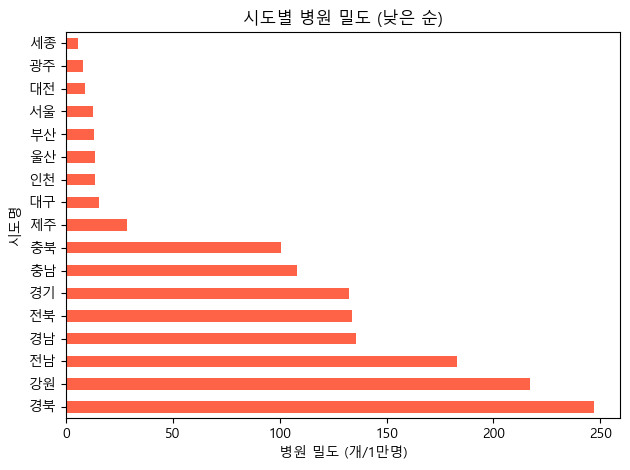

In [86]:
df_human['병원밀도(개/1만명)'].plot(kind='barh', color='tomato') #토마토
plt.xlabel('병원 밀도 (개/1만명)')
plt.title('시도별 병원 밀도 (낮은 순)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [87]:
df_human2 = pd.DataFrame(data_human).set_index('시도명')

general_counts = df_general['시도코드명'].value_counts()
oriental_counts = df_oriental['시도코드명'].value_counts()

df_human2['일반병원수'] = general_counts
df_human2['한방병원수'] = oriental_counts
df_human2 = df_human2.fillna(0)


df_human2['일반병원 밀도'] = (df_human2['일반병원수'] / (df_human2['인구(천명)'] * 1000)) * 10000
df_human2['한방병원 밀도'] = (df_human2['한방병원수'] / (df_human2['인구(천명)'] * 1000)) * 10000

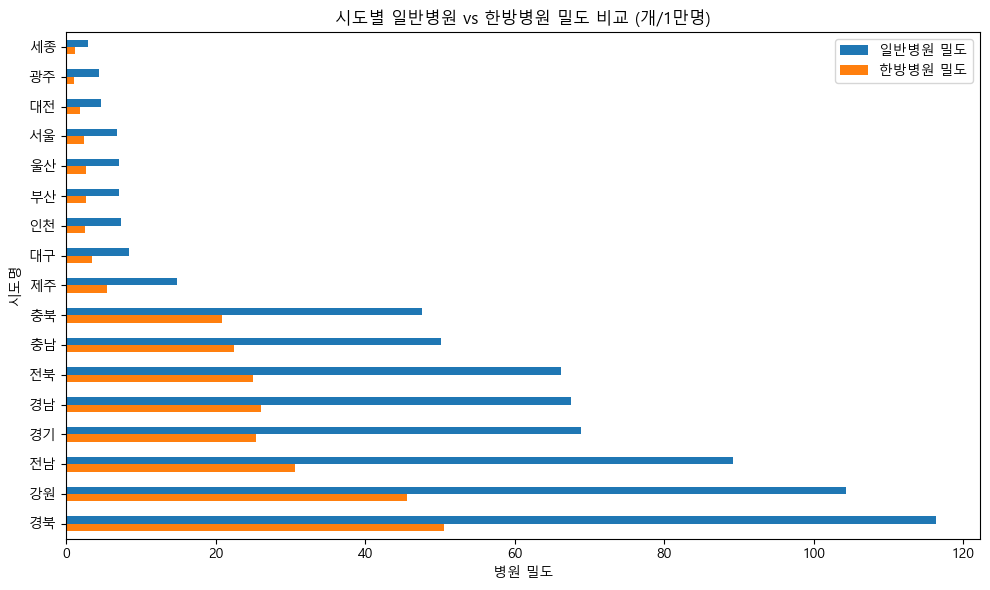

In [88]:
df_human2[['일반병원 밀도', '한방병원 밀도']].sort_values('일반병원 밀도').plot(kind='barh', figsize=(10,6))
plt.title('시도별 일반병원 vs 한방병원 밀도 비교 (개/1만명)')
plt.xlabel('병원 밀도')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 2-4. KMeans 클러스터링
병원 위치 기반으로 지리적 밀접도 계산.
밀집 지역, 중간 밀도, 외곽 클러스터, 섬(단절됨) 클러스터, 특이 위치 클러스터 등을 알 수 있음

In [151]:
coords_all = df_final[['좌표(X)', '좌표(Y)']].dropna()   
coords_general = df_general[['좌표(X)', '좌표(Y)']].dropna()
coords_oriental = df_oriental[['좌표(X)', '좌표(Y)']].dropna()

In [152]:
kmeans_all = KMeans(n_clusters=5, random_state=42)
kmeans_general = KMeans(n_clusters=5, random_state=42)
kmeans_oriental = KMeans(n_clusters=5, random_state=42)
coords_all['cluster'] = kmeans_all.fit_predict(coords_all)
coords_general['cluster'] = kmeans_general.fit_predict(coords_general)
coords_oriental['cluster'] = kmeans_oriental.fit_predict(coords_oriental)

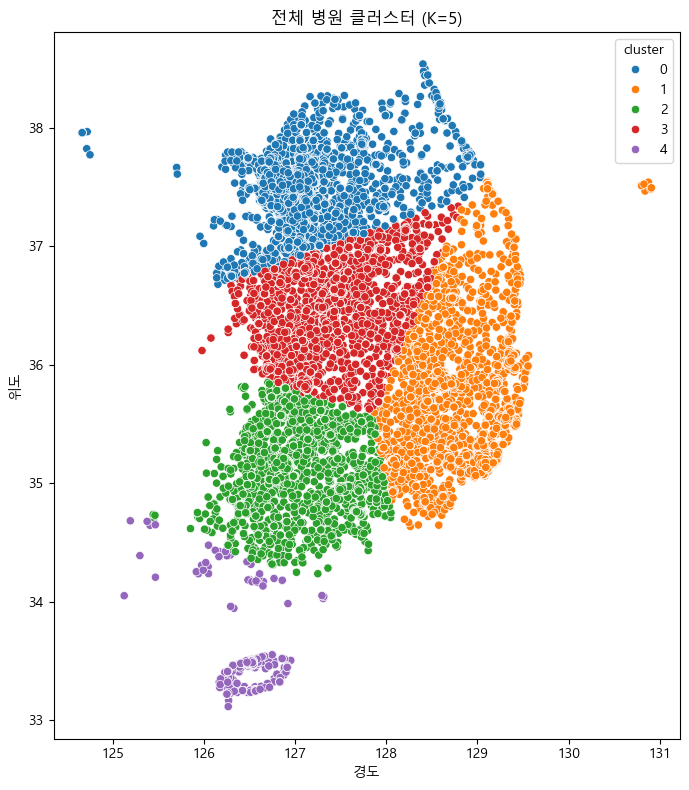

In [153]:
plt.figure(figsize=(7, 8))
sns.scatterplot(data=coords_all, x='좌표(X)', y='좌표(Y)', hue='cluster', palette='tab10')
plt.title('전체 병원 클러스터 (K=5)')


plt.xlabel('경도')
plt.ylabel('위도')
plt.tight_layout()
plt.show()

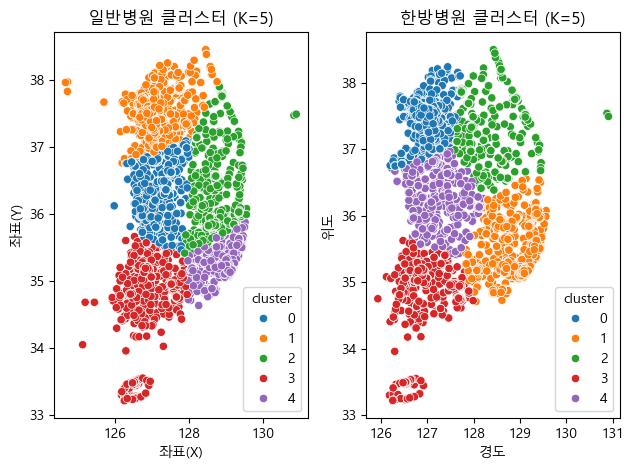

In [154]:
plt.subplot(1, 2, 1)
sns.scatterplot(data=coords_general, x='좌표(X)', y='좌표(Y)', hue='cluster', palette='tab10')
plt.title('일반병원 클러스터 (K=5)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=coords_oriental, x='좌표(X)', y='좌표(Y)', hue='cluster', palette='tab10')
plt.title('한방병원 클러스터 (K=5)')

plt.xlabel('경도')
plt.ylabel('위도')
plt.tight_layout()
plt.show()

In [155]:
coords_all['cluster'].value_counts().sort_index()

cluster
0    43023
1    18253
2     5920
3    10167
4     1096
Name: count, dtype: int64

In [156]:
coords_all.groupby('cluster')[['좌표(X)', '좌표(Y)']].mean()

,좌표(X),좌표(Y)
cluster,,
0,127.015008,37.490883
1,128.845133,35.546589
2,126.995738,35.093322
3,127.320013,36.397417
4,126.504188,33.473750


In [157]:
for c in sorted(coords_all['cluster'].unique()):
    idx = coords_all[coords_all['cluster'] == c].index
    top_sido = df_final.loc[idx, '시도코드명'].value_counts().head(5)
    print(f"클러스터 {c} 주요 지역:", top_sido.to_dict())
    


클러스터 0 주요 지역: {'서울': 19265, '경기': 17749, '인천': 3817, '강원': 1718, '충남': 458}
클러스터 1 주요 지역: {'부산': 5585, '대구': 4170, '경남': 3900, '경북': 2949, '울산': 1429}
클러스터 2 주요 지역: {'전남': 2578, '광주': 2325, '전북': 780, '경남': 237}
클러스터 3 주요 지역: {'충남': 2403, '대전': 2355, '충북': 2188, '전북': 2165, '세종': 464}
클러스터 4 주요 지역: {'제주': 1043, '전남': 53}


In [158]:
print('[일반병원]')
for c in sorted(coords_general['cluster'].unique()):
    idx = coords_general[coords_general['cluster'] == c].index
    top_sido = df_final.loc[idx, '시도코드명'].value_counts().head(5)
    print(f"클러스터 {c} 주요 지역:", top_sido.to_dict())

[일반병원]
클러스터 0 주요 지역: {'대전': 1264, '전북': 1249, '충남': 1210, '충북': 933, '세종': 244}
클러스터 1 주요 지역: {'서울': 10583, '경기': 9239, '인천': 2049, '강원': 660, '충남': 118}
클러스터 2 주요 지역: {'대구': 2261, '경북': 1572, '강원': 290, '충북': 101, '경남': 76}
클러스터 3 주요 지역: {'광주': 1310, '전남': 1284, '제주': 541, '전북': 209, '경남': 53}
클러스터 4 주요 지역: {'부산': 3040, '경남': 1955, '울산': 742, '경북': 33}


In [159]:
print('[한방병원]')
for c in sorted(coords_oriental['cluster'].unique()):
    idx = coords_oriental[coords_oriental['cluster'] == c].index
    top_sido = df_final.loc[idx, '시도코드명'].value_counts().head(5)
    print(f"클러스터 {c} 주요 지역:", top_sido.to_dict())

[한방병원]
클러스터 0 주요 지역: {'서울': 3644, '경기': 3376, '인천': 701, '충남': 95, '강원': 20}
클러스터 1 주요 지역: {'부산': 1152, '대구': 910, '경남': 770, '경북': 490, '울산': 275}
클러스터 2 주요 지역: {'강원': 395, '경북': 174, '충북': 133, '경기': 34}
클러스터 3 주요 지역: {'전남': 441, '광주': 329, '제주': 199, '전북': 45, '경남': 18}
클러스터 4 주요 지역: {'대전': 506, '전북': 504, '충남': 500, '충북': 319, '세종': 100}


## 3. 진료과목 정보 데이터 분석

### 3-1. 데이터 전처리   

데이터 : csv로 변환한 엑셀파일. 데이터의 구조를 살펴보고 전처리 작업을 진행합니다.

In [160]:
df_detail = pd.read_csv(r"C:\Users\zappe\Desktop\Test_for_python\데이터분석개론\team_proj\전국 병의원 및 약국 현황 2024.12\의료기관별상세정보서비스_03_진료과목정보 2024.12.csv",encoding='utf-8')

In [161]:
df_detail.head()

,암호화요양기호,요양기관명,진료과목코드,진료과목코드명,과목별 전문의수,선택진료 의사수
0,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 여의도성모병원,1,내과,34,0
1,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,중앙대학교병원,1,내과,59,0
2,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQyIy...,한림대학교 강남성심병원,1,내과,39,0
3,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,한림대학교 한강성심병원,1,내과,1,0
4,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,서울대학교병원,1,내과,183,0


In [162]:
df_detail.isnull().sum() # 결측치 확인

암호화요양기호     0
요양기관명       0
진료과목코드      0
진료과목코드명     0
과목별 전문의수    0
선택진료 의사수    0
dtype: int64

In [163]:
df_detail['진료과목코드명'].unique()

array(['내과', '신경과', '정신건강의학과', '외과', '정형외과', '신경외과', '심장혈관흉부외과', '성형외과',
       '마취통증의학과', '산부인과', '소아청소년과', '안과', '이비인후과', '피부과', '비뇨의학과',
       '영상의학과', '방사선종양학과', '병리과', '진단검사의학과', '결핵과', '재활의학과', '핵의학과',
       '가정의학과', '응급의학과', '직업환경의학과', '예방의학과', '치과', '구강악안면외과', '치과보철과',
       '치과교정과', '소아치과', '치주과', '치과보존과', '구강내과', '영상치의학과', '구강병리과', '예방치과',
       '통합치의학과', '한방내과', '한방부인과', '한방소아과', '한방안·이비인후·피부과', '한방신경정신과',
       '침구과', '한방재활의학과', '사상체질과', '한방응급'], dtype=object)

In [164]:
df_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414896 entries, 0 to 414895
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   암호화요양기호   414896 non-null  object
 1   요양기관명     414896 non-null  object
 2   진료과목코드    414896 non-null  int64 
 3   진료과목코드명   414896 non-null  object
 4   과목별 전문의수  414896 non-null  int64 
 5   선택진료 의사수  414896 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 19.0+ MB


내과, 이비인후과, 심장혈관흉부외과, 소아청소년과, 재할의학과, 결핵과, 한방내과, 한방소아과, 한방안·이비인후·피부과, 한방재활의학과 고름.  
하단 내용 참고함^,^...

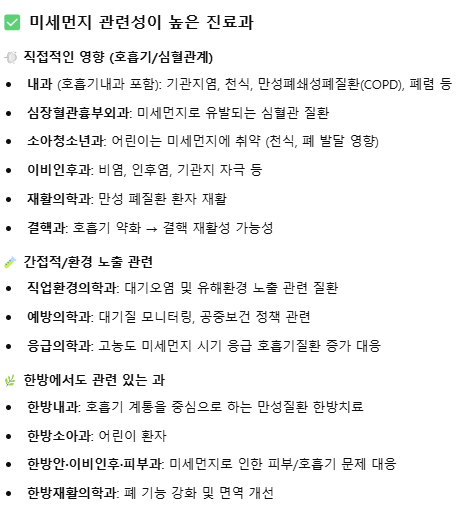

In [165]:
dust_related_depts = [
    '내과', '이비인후과', '심장혈관흉부외과', '소아청소년과',
    '재활의학과', '결핵과', '한방내과', '한방소아과',
    '한방안·이비인후·피부과', '한방재활의학과'
]

df_detail = df_detail[df_detail['진료과목코드명'].isin(dust_related_depts)]

df_detail.drop(columns=['암호화요양기호'],inplace=True)

In [166]:
df_detail['진료과목코드명'].unique()

array(['내과', '심장혈관흉부외과', '소아청소년과', '이비인후과', '결핵과', '재활의학과', '한방내과',
       '한방소아과', '한방안·이비인후·피부과', '한방재활의학과'], dtype=object)

In [167]:
df_detail.head()

,요양기관명,진료과목코드,진료과목코드명,과목별 전문의수,선택진료 의사수
0,가톨릭대학교 여의도성모병원,1,내과,34,0
1,중앙대학교병원,1,내과,59,0
2,한림대학교 강남성심병원,1,내과,39,0
3,한림대학교 한강성심병원,1,내과,1,0
4,서울대학교병원,1,내과,183,0


In [168]:
df_detail = pd.merge(df_detail, df_final[['요양기관명', '좌표(X)', '좌표(Y)','시도코드명','시군구코드명'	,'읍면동']], on='요양기관명', how='left')

df_detail.head()

,요양기관명,진료과목코드,진료과목코드명,과목별 전문의수,선택진료 의사수,좌표(X),좌표(Y),시도코드명,시군구코드명,읍면동
0,가톨릭대학교 여의도성모병원,1,내과,34,0,126.936752,37.518325,서울,영등포구,여의도동
1,중앙대학교병원,1,내과,59,0,126.960784,37.506748,서울,동작구,흑석동
2,한림대학교 강남성심병원,1,내과,39,0,126.908653,37.493726,서울,영등포구,대림동
3,한림대학교 한강성심병원,1,내과,1,0,126.909681,37.523170,서울,영등포구,영등포동7가
4,서울대학교병원,1,내과,183,0,126.999017,37.579715,서울,종로구,연건동


In [169]:
df_detail[['좌표(X)', '좌표(Y)']].isna().any(axis=1).sum()

32

In [170]:
df_detail['진료과목코드명'].value_counts()

진료과목코드명
한방내과            110656
내과              101879
한방소아과           101221
한방안·이비인후·피부과     97729
한방재활의학과          85542
소아청소년과           77866
이비인후과            70822
재활의학과            21666
심장혈관흉부외과          3051
결핵과                931
Name: count, dtype: int64

In [171]:
df_detail.isnull().sum()

요양기관명          0
진료과목코드         0
진료과목코드명        0
과목별 전문의수       0
선택진료 의사수       0
좌표(X)         32
좌표(Y)         32
시도코드명          0
시군구코드명         0
읍면동         3251
dtype: int64

C:\Users\zappe\AppData\Local\Temp\ipykernel_38676\2451344798.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=counts.index, x=counts.values, palette=palette)


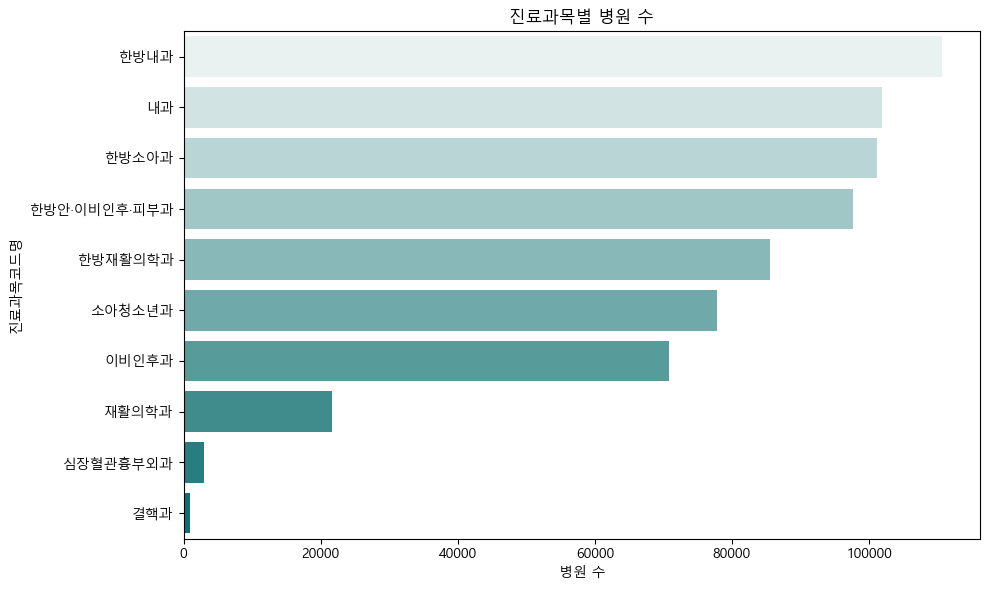

In [172]:
palette = sns.light_palette("teal", n_colors=10)
plt.rc('font', family='Malgun Gothic')

counts = df_detail['진료과목코드명'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(y=counts.index, x=counts.values, palette=palette)
plt.title("진료과목별 병원 수")
plt.xlabel("병원 수")
plt.tight_layout()
plt.show()

In [173]:
df_detail_nodf_no_rehab = df_detail[~df_detail['진료과목코드명'].str.contains('재활', na=False)].copy()

<Axes: xlabel='좌표(X)', ylabel='좌표(Y)'>

c:\Users\zappe\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\zappe\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


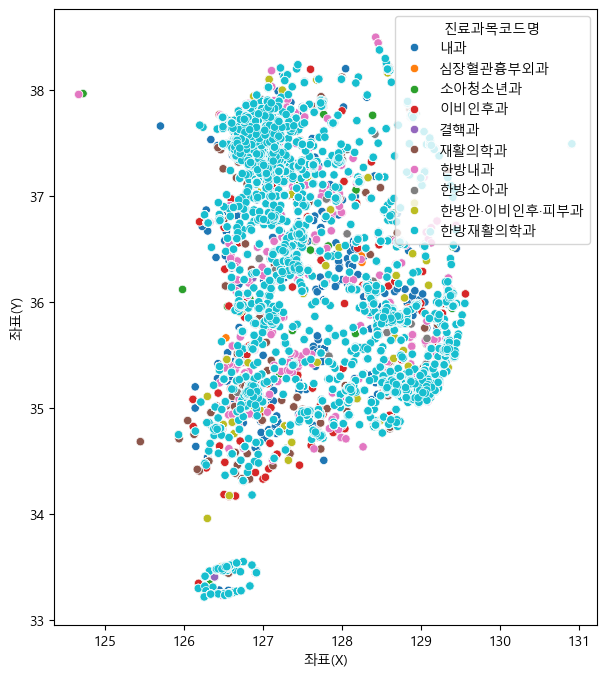

In [174]:
plt.figure(figsize=(7,8))
sns.scatterplot(data=df_detail, x='좌표(X)', y='좌표(Y)', hue='진료과목코드명')

<Axes: xlabel='좌표(X)', ylabel='좌표(Y)'>

c:\Users\zappe\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


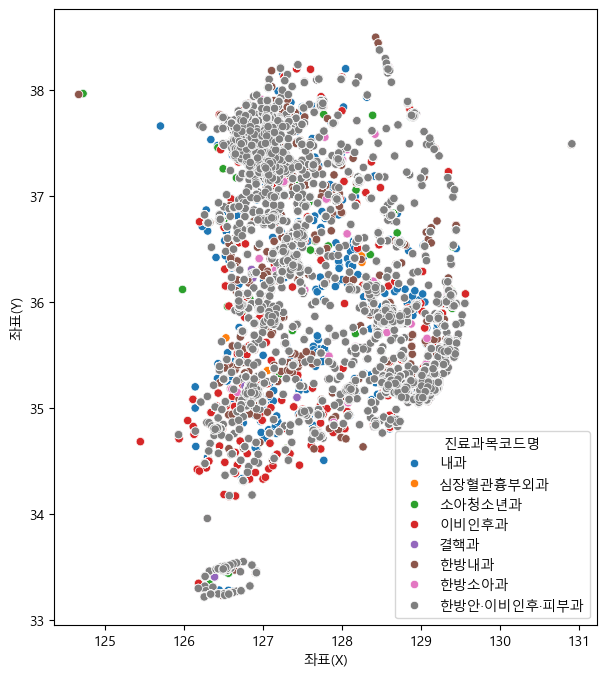

In [175]:
plt.figure(figsize=(7,8))
sns.scatterplot(data=df_detail_nodf_no_rehab, x='좌표(X)', y='좌표(Y)', hue='진료과목코드명')

In [176]:
data_human = {
    '시도명': ['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종시', '경기',
             '강원', '충북', '충남', '전북', '전남', '경북', '경남', '제주'],
    '인구(천명)': [15567, 4282, 2679, 2788, 2933, 2728, 1048, 818, 1342,
             91, 219, 265, 220, 144, 138, 312, 365],
    '인구밀도': [9400, 3284, 2360, 3009, 1463, 1474, 1106, 387, 13781,
                1525, 1627, 2204, 1768, 1768, 2611, 3267, 677]
} # 시도별 인구수 및 인구밀도 데이터. 2023년 확정인구 기준. 
df_human2 = pd.DataFrame(data_human).set_index('시도명')

In [177]:
df_detail2 = df_detail.drop_duplicates(subset='요양기관명')

hospital_counts = df_detail2['시도코드명'].value_counts()


df_human2['병원수'] = hospital_counts
df_human2['병원수'] = df_human2['병원수'].fillna(0)
df_human2['병원밀도(개/1만명)'] = (df_human2['병원수'] / (df_human2['인구(천명)'] * 1000)) * 10000
df_human2.sort_values(by='병원밀도(개/1만명)', ascending=True,inplace=True)


In [178]:
df_human2

,인구(천명),인구밀도,병원수,병원밀도(개/1만명)
시도명,,,,
세종시,818,387,0.0,0.000000
광주,2933,1463,868.0,2.959427
대전,2728,1474,901.0,3.302786
울산,1048,1106,477.0,4.551527
인천,2788,3009,1418.0,5.086083
서울,15567,9400,8619.0,5.536712
부산,4282,3284,2536.0,5.922466
대구,2679,2360,1706.0,6.368048
제주,365,677,341.0,9.342466


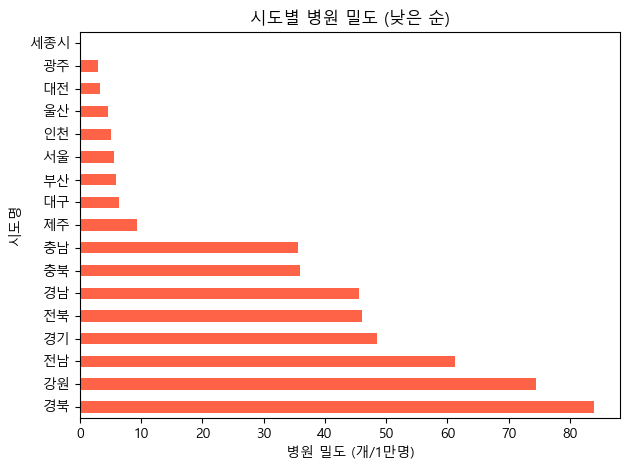

In [179]:
df_human2['병원밀도(개/1만명)'].plot(kind='barh', color='tomato') #토마토
plt.xlabel('병원 밀도 (개/1만명)')
plt.title('시도별 병원 밀도 (낮은 순)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [180]:
df_final.to_csv("df_final.csv", index=False, encoding='utf-8-sig')

In [181]:
low_density = df_human[df_human['병원밀도(개/1만명)'] < 10]
low_density

,인구(천명),인구밀도,병원수,병원밀도(개/1만명)
시도명,,,,
세종,818,387,464,5.672372
광주,2933,1463,2326,7.930447
대전,2728,1474,2355,8.632698


In [182]:
low_density2 = df_human2[df_human2['병원밀도(개/1만명)'] < 5]
low_density2

,인구(천명),인구밀도,병원수,병원밀도(개/1만명)
시도명,,,,
세종시,818,387,0.0,0.000000
광주,2933,1463,868.0,2.959427
대전,2728,1474,901.0,3.302786
울산,1048,1106,477.0,4.551527


# 결론

세종,광주,대전 밷.